# Stock Price Prediction in Python with PyTorch using an LSTM-based Architecture

Looking at the past $x$ days and predict the stock price for the next day

In [1]:
# Working with arrays
import numpy as np

# Visualisations
import matplotlib.pyplot as plt

# Data
import yfinance as yf

# Neural network
import torch
import torch.nn as nn
import torch.optim as optim

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Model evaluation
from sklearn.metrics import root_mean_squared_error

In [2]:
# CPU or GPU use depending on device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# Data collection
ticker = 'AAPL'	# Ticker symbol for Apple
df = yf.download(ticker, '2020-01-01')
df.head()

/var/folders/1y/t24y4yvn2k9dy8fng6q_pxvh0000gn/T/ipykernel_99303/776533669.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2020-01-01')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.538513,72.598892,71.292304,71.545890,135480400
2020-01-03,71.833305,72.594071,71.608700,71.765682,146322800
2020-01-06,72.405678,72.444321,70.703012,70.954188,118387200
2020-01-07,72.065155,72.671348,71.845377,72.415345,108872000
2020-01-08,73.224411,73.526303,71.768086,71.768086,132079200


<Axes: xlabel='Date'>

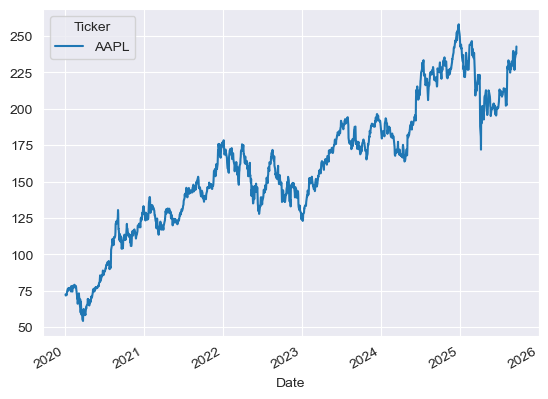

In [4]:
df['Close'].plot()

In [5]:
# Standardising so mean is zero and standard deviation is one
scaler = StandardScaler()
df2 = df.copy()
df2['Close'] = scaler.fit_transform(df2['Close'])

In [6]:
# Looking at first 29 days to predict the 30th day
days = 30
data = []

for i in range(len(df2) - days):
    data.append(df2['Close'][i : (i+days)])

data = np.array(data)

train_size = int(0.8 * len(df2))

X_train = torch.from_numpy(data[ : train_size, : -1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[ : train_size, -1, :]).type(torch.Tensor).to(device)

X_test = torch.from_numpy(data[train_size:, : -1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

Shuffling the data is not done because the aim is to predict using sequential data.

In [7]:
class PredictionModel(nn.Module):
	def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
		super(PredictionModel, self).__init__()

		self.num_layers = num_layers	# Number of layers
		self.hidden_dim = hidden_dim	# Number of neurones per layer

		self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)	# Long-short term memory

		self.fc = nn.Linear(hidden_dim, output_dim)

	# Forward pass
	def forward(self, x):
		h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
		c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

		out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
		out = self.fc(out[:, -1, :])

		return out

In [8]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [9]:
criterion = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr=0.01)

In [10]:
# Training
num_epochs = 200

for i in range(num_epochs):
    # Make a prediction
    y_train_pred = model(X_train)

    # Calculate loss of that prediction
    loss = criterion(y_train_pred, y_train)

    # After every 25 epochs, print the loss
    if i % 25 == 0:
        print(i, loss.item())

    # Optimisation
    optimiser.zero_grad()   # Start at a gradient of zero
    loss.backward()   # Backpropagation
    optimiser.step()  # Take a step towards a more optimal direction

0 0.7493097186088562
25 0.014960317872464657
50 0.005905089434236288
75 0.005287834443151951
100 0.004900803789496422
125 0.004587572067975998
150 0.004306938499212265
175 0.004056286532431841


In [12]:
# Predicting on test data
model.eval()

y_test_pred = model(X_test)

# Convert standardised data back to its original scale
y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test= scaler.inverse_transform(y_test.detach().cpu().numpy())

In [13]:
# Model evaluation

train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

print(
    train_rmse,
    test_rmse,
    sep='\n'
)

2.8091518878936768 5.006438732147217


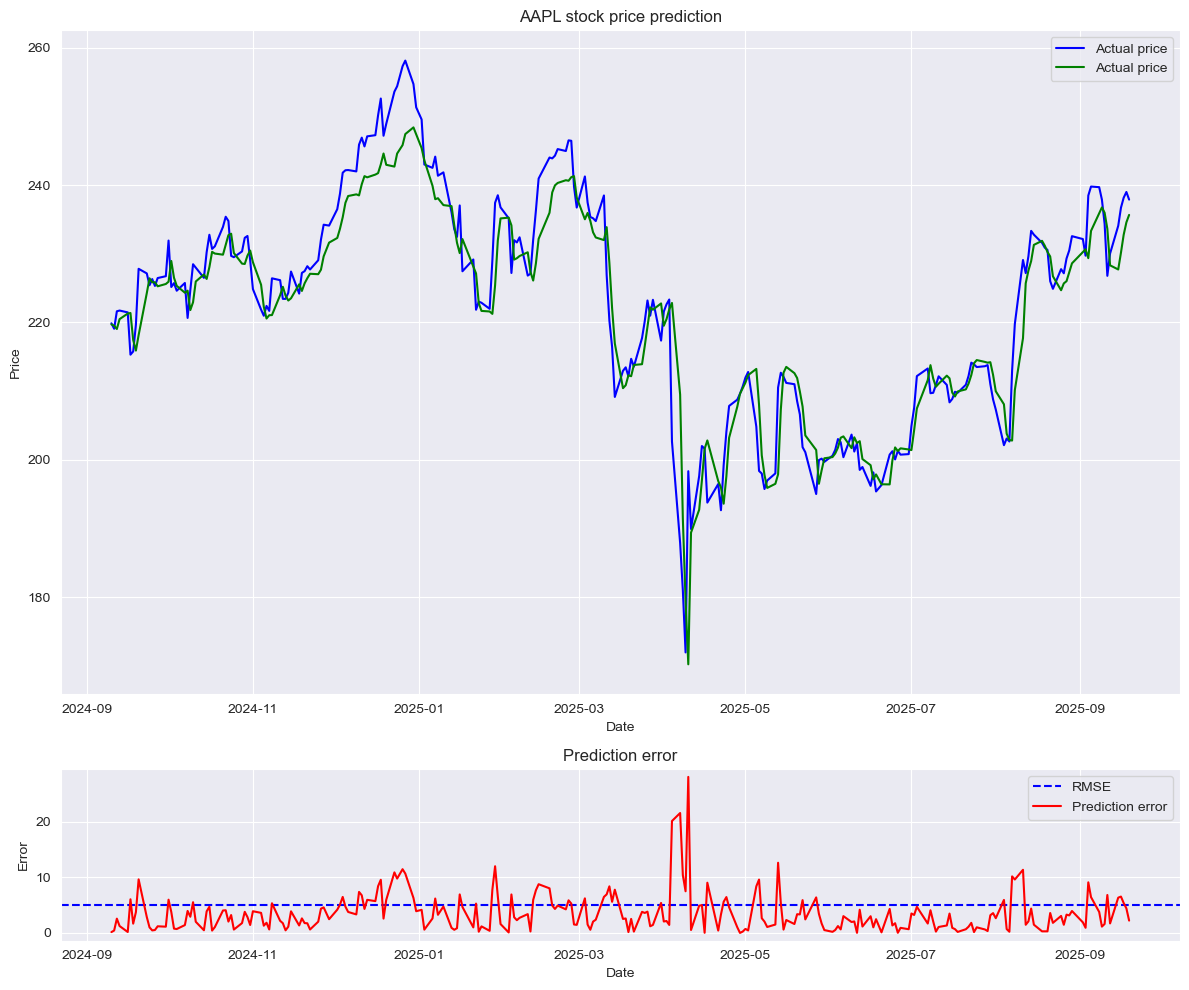

In [14]:
fig = plt.figure(figsize=(12,10))

gs = fig.add_gridspec(4, 1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df2.iloc[-len(y_test):].index, y_test, color='blue', label='Actual price')
ax1.plot(df2.iloc[-len(y_test):].index, y_test_pred, color='green', label='Actual price')
ax1.legend()
plt.title(f'{ticker} stock price prediction')
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color='blue', linestyle='--', label='RMSE')
ax2.plot(df2.iloc[-len(y_test):].index, abs(y_test - y_test_pred), color='red', label='Prediction error')
ax2.legend()
plt.title('Prediction error')
plt.xlabel('Date')
plt.ylabel('Error')

plt.tight_layout()
plt.show()